In [1]:
 import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import urllib
import re
import time
%matplotlib inline

In [4]:
def get_tot_pages(company, company_url):
    website_raw = requests.get(company_url, headers={'User-Agent':'test'}).text
    soup = BeautifulSoup(website_raw, 'html.parser')
    ptot = soup.find('h1',{'class':'results-context-header__context'}).find('span', {'class':'results-context-header__job-count'}).get_text()
    print("Company: ", company, "; Total search result:", ptot)
    try:
        ptot = int(ptot)//25+1
    except:
        ptot = 40
    return ptot

In [5]:
companies = {'Facebook':'https://www.linkedin.com/jobs/search/?f_C=10667&geoId=103644278&keywords=data%20scientist&location=United%20States&sortBy=DD',
    'Apple':'https://www.linkedin.com/jobs/search/?f_C=162479&geoId=103644278&keywords=data%20scientist&location=United%20States&sortBy=DD',
    'Google':'https://www.linkedin.com/jobs/search/?f_C=1441&geoId=103644278&keywords=data%20scientist&location=United%20States&sortBy=DD',
    'Amazon':'https://www.linkedin.com/jobs/search/?f_C=1586&geoId=103644278&keywords=data%20scientist&location=United%20States&sortBy=DD',
    'Microsoft':'https://www.linkedin.com/jobs/search/?f_C=1035&geoId=103644278&keywords=data%20scientist&location=United%20States&sortBy=DD'}

In [6]:
def scrape_each_company(company, company_url):
    url_template = company_url + '&start='
    tot_pg = get_tot_pages(company, company_url)

    for page_num in np.arange(tot_pg):
        #create link for each website page
        link = url_template + str(page_num*25)
        #user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36'
        website_raw = requests.get(link, headers={'User-Agent':user_agent}).text
        soup = BeautifulSoup(website_raw, 'html.parser')
        #print(soup.prettify())
        #find job titles from each 'h3' element
        title_list.extend([title.get_text().strip() for title in soup.find_all('h3', {'class': 'result-card__title job-result-card__title'})])
        #find company name from each 'h4' element
        #Note that here I changed indicator for company to h4 because some jobs do not have company name just marked "openly"
        company_list.extend([company_name.get_text().strip() for company_name in soup.find_all('h4')])
        #find company location from each 'span' element
        location_list.extend([loc.get_text().strip() for loc in soup.find_all('span',{'class':'job-result-card__location'})])
        #find job posting date from each 'time' element
        date_list.extend([date.get('datetime') for date in soup.find_all('time')])
        #get url for each job on the page
        job_links = soup.find_all('a',{'class':'result-card__full-card-link'})
        for job_link in job_links:
            job_url = job_link.get('href')
            #print(job_url)
            job_web_raw = requests.get(job_url).text
            job_soup = BeautifulSoup(job_web_raw, 'html.parser')
            #print(job_soup.prettify())
            tag = job_soup.find('h3', text='Employment type')
            if tag:
                emptype_list.append(tag.find_next_siblings('span')[0].get_text())
            else:
                emptype_list.append('Not Available')
            job_context = job_soup.find('script',{'type':'application/ld+json'})
            #some job does not have descripton
            if job_context:
                job_data = json.loads(job_context.get_text())
                level_list.append(job_data['experienceRequirements'])
                industry_list.append(job_data['industry'])
                raw_description = job_data['description']
                clean_description = re.sub('<[^>]+>', '', raw_description)
                description_list.append(clean_description)
            else:
                level_list.append('Not Available')
                industry_list.append('Not Available')
                description_list.append('Not Available')
        
    return "success"

In [7]:
title_list = []
company_list = []
location_list = []
date_list = []
level_list = []
emptype_list = []
industry_list = []
description_list = []
user_agent = 'test'

for company, company_url in companies.items():
    start_time = time.time()
    status = scrape_each_company(company, company_url)
    used_time = time.time()-start_time
    print(len(title_list))
    print("Scraped jobs from ", company, "Used time(s):", used_time)    

Company:  Facebook ; Total search result: 384
400
Scraped jobs from  Facebook Used time(s): 167.01632690429688
Company:  Apple ; Total search result: 99
500
Scraped jobs from  Apple Used time(s): 37.878639221191406
Company:  Google ; Total search result: 56
575
Scraped jobs from  Google Used time(s): 35.5826530456543
Company:  Amazon ; Total search result: 394
975
Scraped jobs from  Amazon Used time(s): 163.6697118282318
Company:  Microsoft ; Total search result: 325
1325
Scraped jobs from  Microsoft Used time(s): 163.5006844997406


In [ ]:
print(len(title_list))
print(len(company_list))
print(len(location_list))
print(len(date_list))

525
525
525
525


In [ ]:
#store info in pd
df = pd.DataFrame()
df['Title'] = title_list
df['Company'] = company_list
df['Location'] = location_list
df['Post date'] = date_list
df['Seniority level'] = level_list
df['Employment type'] = emptype_list
df['Industry'] = industry_list
df['Description'] = description_list

#double check duplicates
df_short = df.drop_duplicates().reset_index(drop=True)
df.to_csv('/Users/tingtingweng/Documents/linkedin_jobs_big_companies.csv', header=True, index=False)
print("Total scraped jobs: ", df.shape[0], "Distinct scraped jobs:", df_short.shape[0])

Total scraped jobs:  525 Distinct scraped jobs: 126


In [ ]:
df

,Title,Company,Location,Post date,Seniority level,Employment type,Industry,Description
0,"Data Scientist, Analytics - WhatsApp Privacy",Facebook,"Menlo Park, CA",2020-06-11,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...
1,"Data Scientist, Machine Learning",Facebook,"Fremont, CA",2020-06-10,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...
2,"Data Scientist, Analytics-Remote Presence",Facebook,"Bellevue, WA",2020-06-06,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...
3,"Data Scientist, Analytics - AR/VR Portal",Facebook,"Menlo Park, CA",2020-06-04,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...
4,"Data Analyst Lead, Consumer Research",Facebook,"Menlo Park, CA",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...
...,...,...,...,...,...,...,...,...
520,Education Cloud Solution Architect,Microsoft,"Los Angeles, CA",2020-06-05,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Microsoft is on a mission to empower every per...
521,Education Cloud Solution Architect,Microsoft,"San Francisco, CA",2020-06-05,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Microsoft is on a mission to empower every per...
522,Education Cloud Solution Architect,Microsoft,"San Jose, CA",2020-06-05,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Microsoft is on a mission to empower every per...
523,Education Cloud Solution Architect,Microsoft,"San Diego, CA",2020-06-05,Not Applicable,Full-time,"Computer Hardware,Computer Software,Informatio...",Microsoft is on a mission to empower every per...


In [ ]:
ds_jobs = pd.read_csv('/Users/tingtingweng/Documents/linkedin_jobs_big_companies.csv',parse_dates=['Post date'])

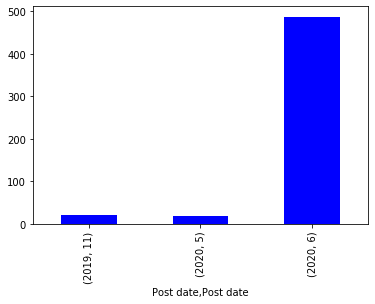

In [ ]:
ds_jobs.groupby([ds_jobs['Post date'].dt.year, ds_jobs['Post date'].dt.month]).size().plot(kind='bar',color='b')

In [ ]:
df['Month'] = ds_jobs['Post date'].dt.month

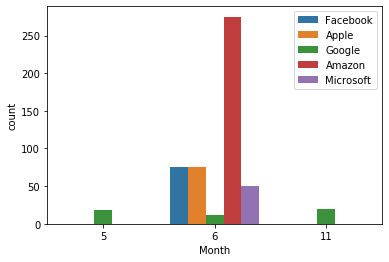

In [ ]:
g = sns.countplot(x='Month', data=df, hue='Company')
plt.legend(loc=1)
plt.show(g)

In [ ]:
by_date = df.groupby('Post date').count().reset_index()
by_date.sort_values(by=['Post date'], ascending=False, inplace=True)

In [ ]:
by_date.reset_index()

,index,Post date,Title,Company,Location,Seniority level,Employment type,Industry,Description
0,19,2020-06-19,155,155,155,155,155,155,155
1,18,2020-06-18,148,148,148,148,148,148,148
2,17,2020-06-17,54,54,54,54,54,54,54
3,16,2020-06-16,12,12,12,12,12,12,12
4,15,2020-06-15,2,2,2,2,2,2,2
5,14,2020-06-14,3,3,3,3,3,3,3
6,13,2020-06-13,3,3,3,3,3,3,3
7,12,2020-06-12,15,15,15,15,15,15,15
8,11,2020-06-11,5,5,5,5,5,5,5
9,10,2020-06-10,3,3,3,3,3,3,3


In [ ]:
df_june = df.loc[df['Month'] == 6]
df_june_order = df_june.sort_values(by=['Post date'], ascending=True).reset_index()
df_june_order

,index,Title,Company,Location,Post date,Seniority level,Employment type,Industry,Description,Month
0,37,Data Science Manager,Facebook,"Menlo Park, CA",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,6
1,34,"Data Science Director, Privacy",Facebook,"Menlo Park, CA",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,6
2,35,Linguistic Engineer,Facebook,"Redmond, WA",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,6
3,36,"Research Scientist, Privacy Research",Facebook,"Washington, DC",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,6
4,74,"Data Scientist, Instagram - Well-being, Trust",Facebook,"New York, NY",2020-06-03,Not Applicable,Full-time,Internet,Facebook's mission is to give people the power...,6
...,...,...,...,...,...,...,...,...,...,...
482,314,"Data Scientist, Ad Sales Ops",Amazon,"Seattle, WA",2020-06-23,Not Applicable,Full-time,"Computer Software,Information Technology and S...",DescriptionAmazon Advertising operates at the ...,6
483,313,Sr. Data Scientist - Finance Operations,Amazon,"Arlington, VA",2020-06-23,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionThe Data Scientist will work closel...,6
484,312,Data Scientist - Forecasting,Amazon,"New York, NY",2020-06-23,Not Applicable,Full-time,"Computer Software,Information Technology and S...",DescriptionWhere will Amazon's growth come fro...,6
485,325,"Manager, Machine Learning Solutions Lab",Amazon,"Herndon, VA",2020-06-23,Mid-Senior level,Full-time,"Computer Software,Information Technology and S...",DescriptionMachine learning (ML) has been stra...,6


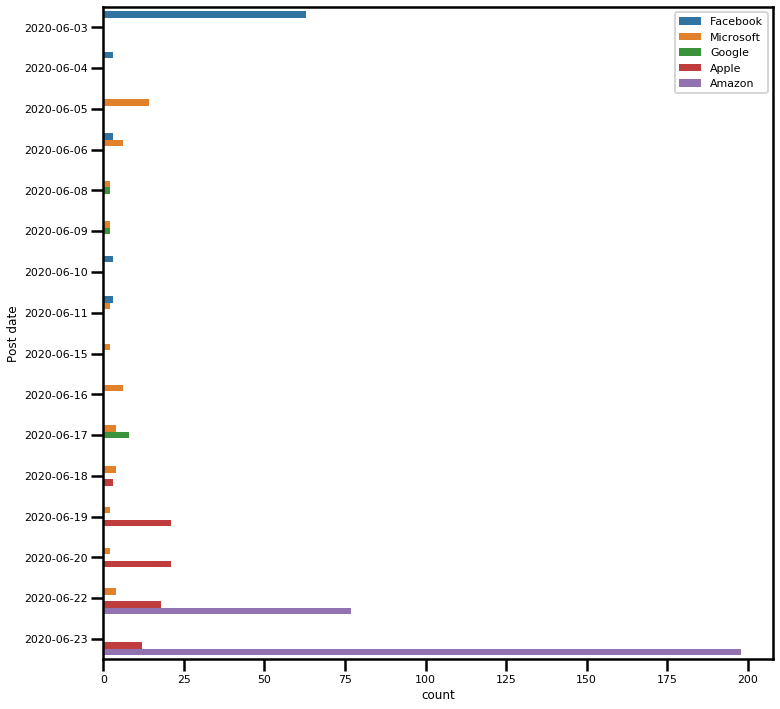

In [ ]:
plt.figure(figsize=(12,12))
g = sns.countplot(y='Post date', data=df_june_order, hue='Company')
plt.legend(loc=1)
plt.show(g)

In [ ]:
by_date = df_june.groupby('Post date').count().sort_values(by=['Post date'], ascending=True).reset_index()
by_date

,Post date,Title,Company,Location,Seniority level,Employment type,Industry,Description,Month
0,2020-06-03,63,63,63,63,63,63,63,63
1,2020-06-04,3,3,3,3,3,3,3,3
2,2020-06-05,14,14,14,14,14,14,14,14
3,2020-06-06,9,9,9,9,9,9,9,9
4,2020-06-08,4,4,4,4,4,4,4,4
5,2020-06-09,4,4,4,4,4,4,4,4
6,2020-06-10,3,3,3,3,3,3,3,3
7,2020-06-11,5,5,5,5,5,5,5,5
8,2020-06-15,2,2,2,2,2,2,2,2
9,2020-06-16,6,6,6,6,6,6,6,6


In [ ]:
by_company = df_june.groupby('Company').count().sort_values(by=['Company'], ascending=True).reset_index()
by_company

,Company,Title,Location,Post date,Seniority level,Employment type,Industry,Description,Month
0,Amazon,275,275,275,275,275,275,275,275
1,Apple,75,75,75,75,75,75,75,75
2,Facebook,75,75,75,75,75,75,75,75
3,Google,12,12,12,12,12,12,12,12
4,Microsoft,50,50,50,50,50,50,50,50


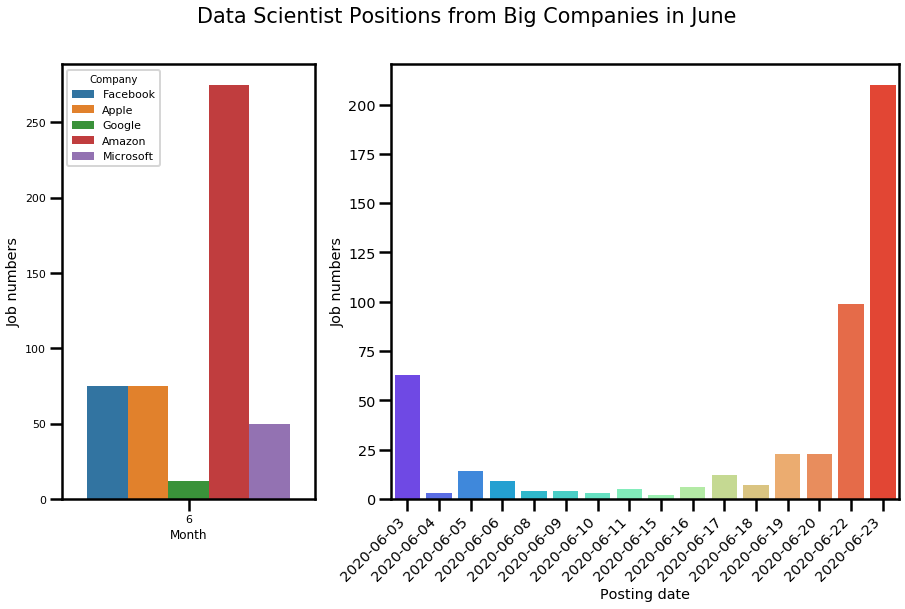

In [ ]:
from matplotlib import gridspec

plt.figure(figsize=(15,8))
sns.set_context('poster',font_scale=0.5)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 4]) 
#f, axes = plt.subplots(1,2)
plt.subplot(gs[0])
sns.countplot(x='Month', data=df_june, hue='Company')
plt.ylabel('Job numbers', fontsize='large')
plt.subplot(gs[1])
sns.barplot(x='Post date', y='Title', data=by_date, palette='rainbow')
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
plt.yticks(fontsize='large')
plt.ylabel('Job numbers', fontsize='large')
plt.xlabel('Posting date', fontsize='large')
plt.suptitle('Data Scientist Positions from Big Companies in June', fontsize='xx-large')
plt.show()

From the left panel in above figure, we can easily observe that Amazon has offered largest numbers (over 200) of data scientist job opennings among big companies in June, 2020. Facebook and Apple tie for second place with approximately 75 job postings respectively. Moreover, it is shown that Google has posted least data scientist jobs among these big companies. Combined with the trend of job numbers changing with posting date, we can see that job posting numbers peaked at specific days when big companies released majority of jobs on those days. For example, Facebook posted most jobs on June 3rd, and Amazon released plenty of jobs on June 22nd and June 23rd, thus leading to the abrupt increase of job opennings on those days. 